# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 2. Простой анализ данных.

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

sns.set(style="whitegrid", font_scale=1.3, palette="Set2")


---
### <font color="orange"><i>Сложная часть</i></font>

### Задача 2

<a target="_blank" href="https://www.yelp.com/">Yelp</a> — веб-сайт для поиска на местном рынке услуг, например ресторанов или парикмахерских, с возможностью добавлять и просматривать рейтинги и обзоры этих услуг. Для популярных бизнесов имеются сотни обзоров. Для обозревателей на сайте предусмотрены элементы социальной сети.

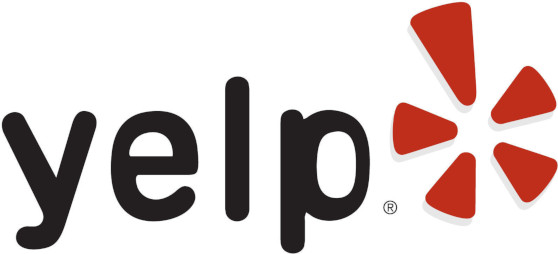

_____________

Вам предоставляется следующая информация о компаниях на Yelp:

Файл `yelp_business.csv`:
* `business_id` — уникальный идентификатор компании;
* `name` — имя компании;
* `address`, `city`, `state` — месторасположении компании;
* `latitude`, `longitude` — географические координаты;
* `categories` — категории услуг компании.

Файл `yelp_review.csv`, содержащий оценки пользователей:
* `business_id` — идентификатор компании, соответствующий файлу `yelp_business.csv`;
* `stars` — поставленная пользователем оценка от 1 до 5.

В целях сокращения объема файла, текстовые отзывы пользователей не были включены.

Оригинальную версию датасета в формате `json` можно посмотреть по <a target="_blank" href="https://www.kaggle.com/yelp-dataset/yelp-dataset/data">ссылке</a>, но использовать нужно выданные данные.

_____________

**Что нужно сделать:** 

* Найти город с наибольшим количеством компаний;
* Для этого города определить районы с наиболее качественными услугами. <a target="_blank" href="https://yandex.ru/company/researches/2017/msk_mobile_map">Пример</a> с несколько другой задачей.
* А также найти рестораны с наилучшими отзывами.


*Далее в условии встречаются различные подсказки, как можно выполнить определенные части задачи. Вы можете их игнорировать и делать иным способом для получения **того же самого промежуточного результата**. Однако, если ваше решение окажется **значительно** менее эффективным (по скорости, количеству и красоте кода) по сравнению с предполагаемым, баллы могут быть снижены.* 

------

#### 1. Город с наибольшим количеством компаний

Загрузим данные из файла `yelp_business.csv` с помощью функции `pd.read_csv`. Посмотрим на первые несколько строк с помощью метода `head`.

In [46]:
data = pd.read_csv("yelp_business.csv", index_col=0)
data.head()

business_id                        name neighborhood  \
0  FYWN1wneV18bWNgQjJ2GNg          "Dental by Design"          NaN   
1  He-G7vWjzVUysIKrfNbPUQ       "Stephen Szabo Salon"          NaN   
2  KQPW8lFf1y5BT2MxiSZ3QA     "Western Motor Vehicle"          NaN   
3  8DShNS-LuFqpEWIp0HxijA          "Sports Authority"          NaN   
4  PfOCPjBrlQAnz__NXj9h_w  "Brick House Tavern + Tap"          NaN   

                            address            city state postal_code  \
0        "4855 E Warner Rd, Ste B9"       Ahwatukee    AZ       85044   
1              "3101 Washington Rd"        McMurray    PA       15317   
2          "6025 N 27th Ave, Ste 1"         Phoenix    AZ       85017   
3  "5000 Arizona Mills Cr, Ste 435"           Tempe    AZ       85282   
4                    "581 Howe Ave"  Cuyahoga Falls    OH       44221   

    latitude   longitude  is_open  \
0  33.330690 -111.978599        1   
1  40.291685  -80.104900        1   
2  33.524903 -112.115310        1   
3  33.383147 -111.964725        0   
4  41.119535  -81.475690        1   

                                          categories  
0  Dentists;General Dentistry;Health & Medical;Or...  
1  Hair Stylists;Hair Salons;Men's Hair Salons;Bl...  
2  Departments of Motor Vehicles;Public Services ...  
3                            Sporting Goods;Shopping  
4  American (New);Nightlife;Bars;Sandwiches;Ameri...

Найдем пять городов, по которым присутствует информация о наибольшем количестве компаний. В таблице укажем город (название) и количество компаний в этом городе.

In [47]:
five_max = (
    data.groupby(by="city")
    .size()
    .sort_values(ascending=False)
    .head(5)
    .reset_index()
    .rename(columns={0: "business_count"})
)
five_max

city  business_count
0   Las Vegas           26775
1     Phoenix           17213
2     Toronto           17206
3   Charlotte            8553
4  Scottsdale            8228

Пусть `N` &mdash; город с наибольшим количеством компаний. Оставим в таблице только записи, соответствующие городу `N`. Нанесем все эти компании на график, в котором по оси $x$ отметим долготу, а по оси $y$ &mdash; широту.

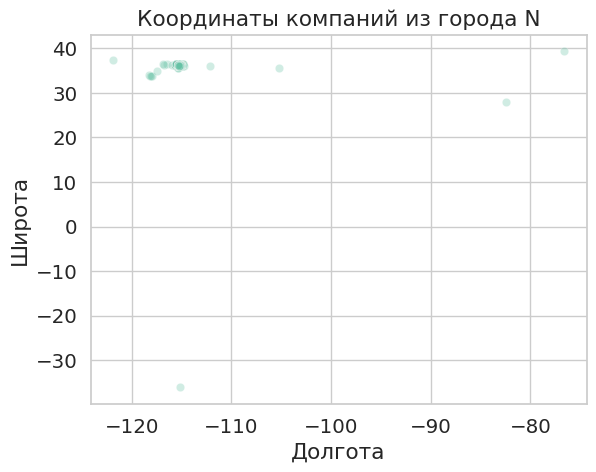

In [48]:
N = five_max.city[0]
data_N = data[data.city == N]
sns.scatterplot(data=data_N, x="longitude", y="latitude", alpha=0.3).set(
    xlabel="Долгота", ylabel="Широта", title="Координаты компаний из города N"
)
plt.show()

Сам город находится в сгустке точек. Есть какие-то компании, которые приписаны к этому городу, но находятся далеко от него. Избавимся от них, подобрав некоторые границы значений широты и долготы. Изобразим все компании на новом графике, причем постараемся сделать так, чтобы на нем выделялись некоторые улицы. 

Границы значений широты и долготы будем подбирать итеративно, передавая в функцию лишь определенный кусок датасета. Альтернативно можно было бы найти среднее значение, предварительно на глаз исключив слишком выбивающиеся точки.

С каждым разом улицы становятся всё яснее видны.

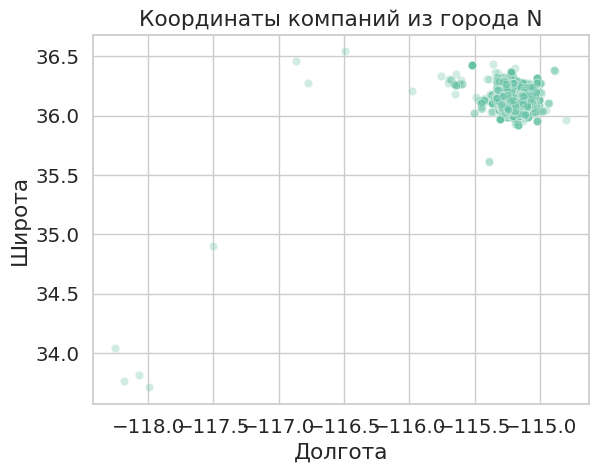

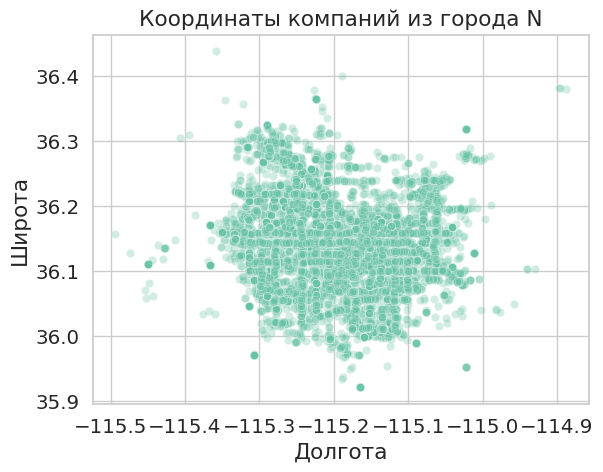

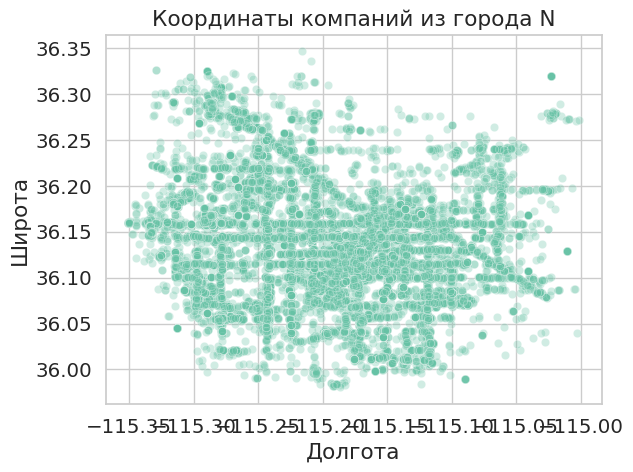

In [49]:
sns.scatterplot(
    data=data_N[
        (data_N.longitude > -120)
        & (data_N.longitude < -114)
        & (data_N.latitude > 30)
    ],
    x="longitude",
    y="latitude",
    alpha=0.3,
).set(
    xlabel="Долгота", ylabel="Широта", title="Координаты компаний из города N"
)
plt.show()
sns.scatterplot(
    data=data_N[
        (data_N.longitude > -115.5)
        & (data_N.longitude < -114.8)
        & (data_N.latitude > 35.7)
    ],
    x="longitude",
    y="latitude",
    alpha=0.3,
).set(
    xlabel="Долгота", ylabel="Широта", title="Координаты компаний из города N"
)
plt.show()
sns.scatterplot(
    data=data_N[
        (data_N.longitude > -115.351)
        & (data_N.longitude < -115)
        & (data_N.latitude > 35.98)
        & (data_N.latitude < 36.35)
    ],
    x="longitude",
    y="latitude",
    alpha=0.3,
).set(
    xlabel="Долгота", ylabel="Широта", title="Координаты компаний из города N"
)
plt.show()

Подгрузим интерактивную карту города в качестве фона графика. Можно пойти двумя следующими способами.
1. Изучить <a href="https://miptstats.github.io/courses/python/11_plotly.html" target="_blank">материалы</a> по библиотеке <a href="https://plotly.com/python/" target="_blank"><b>Plotly</b></a>. Возможно, потребуется также заглянуть в документацию.
1. Поразбираться с библиотекой <a href="https://github.com/python-visualization/folium" target="_blank"><b>Folium</b></a>. Посмотрите множество <a href="https://nbviewer.org/github/python-visualization/folium/tree/main/examples/" target="_blank">примеров</a>, может также помочь <a href="https://proglib.io/p/python-web-map" target="_blank">статья на русском</a>.

In [50]:
fig = px.scatter_mapbox(
    data_N,
    lat="latitude",
    lon="longitude",
    center=dict(lat=36.14, lon=-115.2),
    hover_name="name",
    color="is_open",
    color_continuous_scale=["red", "green"],
    zoom=10,
    mapbox_style="stamen-terrain",
)
fig.update_layout(mapbox_style="open-street-map")
fig.write_html("map_all_companies.html")
fig

#### 2. Оценки компаний

Для выполнения задания посчитаем среднюю оценку каждой компании, а также количество выставленных оценок.

Загрузим таблицу оценок `yelp_review.csv`.

In [51]:
data_review = pd.read_csv("yelp_review.csv", index_col=0)
data_review.head()

business_id  stars
0  AEx2SYEUJmTxVVB18LlCwA      5
1  VR6GpWIda3SfvPC-lg9H3w      5
2  CKC0-MOWMqoeWf6s-szl8g      5
3  ACFtxLv8pGrrxMm6EgjreA      4
4  s2I_Ni76bjJNK9yG60iD-Q      4

В подгруженной таблице оценок оставим только компании города `N`. Для этого установим значения `business_id` в качестве индекса у таблицы оценок и воспользуемся методом `loc`. 

*Подсказка.* Чтобы индекс снова сделать полем таблицы, можно воспользоваться методом `reset_index`.

In [52]:
data_review = (
    data_review.set_index("business_id").loc[data_N.business_id].reset_index()
)
data_review.head()

business_id  stars
0  kCoE3jvEtg6UVz5SOD3GVw      4
1  kCoE3jvEtg6UVz5SOD3GVw      1
2  kCoE3jvEtg6UVz5SOD3GVw      5
3  kCoE3jvEtg6UVz5SOD3GVw      5
4  kCoE3jvEtg6UVz5SOD3GVw      5

Теперь посчитаем среднюю оценку каждой компании, а также количество выставленных компании оценок. 

*Подсказка.* Помочь в этом могут функции `groupby` и `aggregate([np.mean, np.size])`.

In [53]:
data_rev_group = data_review.groupby(by="business_id").aggregate(
    mean_reat=("stars", "mean"), rev_number=("stars", "count")
)

Назовем колонки таблицы красивыми именами, изменив `<имя таблицы>.columns`, после чего напечатаем несколько строк полученной таблицы. Красивые имена &mdash; то, что будет понятно простому человеку при чтении результатов.

In [54]:
data_rev_group.columns = ["mean_rating", "reviews_number"]
data_rev_group.head()

mean_rating  reviews_number
business_id                                        
--9e1ONYQuAa-CB_Rrw7Tw     4.088904            1451
--DdmeR16TRb3LsjG0ejrQ     3.200000               5
--WsruI0IGEoeRmkErU5Gg     4.928571              14
--Y7NhBKzLTbNliMUX_wfg     4.875000               8
--e8PjCNhEz32pprnPhCwQ     3.473684              19

Соединим две полученные ранее таблицы по компаниям города `N` в одну.
Для этого сначала установим поле `business_id` в качестве индекса в обеих таблицах с помощью `set_index`. В одной из них это уже должно было быть сделано.
В полученной таблице должны получится поля `latitude`, `longitude`, `categories`, `name`, а также две колонки со средней оценкой компаний и количеством оценок, которые мы посчитали выше.

*Подсказка.* Соединение таблиц можно выполнить с помощью `join`.
Индексы у этих таблиц одинаковые, так что тип джойна не имеет значения.

In [55]:
data_new = data_N.set_index("business_id").join(data_rev_group)
data_new = data_new[
    [
        "latitude",
        "longitude",
        "categories",
        "name",
        "mean_rating",
        "reviews_number",
    ]
]
data_new.head()

latitude   longitude  \
business_id                                     
kCoE3jvEtg6UVz5SOD3GVw  36.207430 -115.268460   
OD2hnuuTJI9uotcKycxg1A  36.197484 -115.249660   
VBHEsoXQb2AQ76J9l8h1uQ  36.085051 -115.119421   
1Jp_hmPNUZArNqzpbm7B0g  36.056382 -115.269332   
DPQnTnNw2PJj7DdENM98Cw  36.105196 -115.056880   

                                                               categories  \
business_id                                                                 
kCoE3jvEtg6UVz5SOD3GVw  Real Estate Services;Real Estate;Home Services...   
OD2hnuuTJI9uotcKycxg1A                            Shopping;Sporting Goods   
VBHEsoXQb2AQ76J9l8h1uQ       Shopping;Jewelry;Watch Repair;Local Services   
1Jp_hmPNUZArNqzpbm7B0g  Home Services;Lighting Fixtures & Equipment;Lo...   
DPQnTnNw2PJj7DdENM98Cw       Nurseries & Gardening;Home & Garden;Shopping   

                                       name  mean_rating  reviews_number  
business_id                                                               
kCoE3jvEtg6UVz5SOD3GVw         "BDJ Realty"     4.000000               5  
OD2hnuuTJI9uotcKycxg1A        "Soccer Zone"     1.444444               9  
VBHEsoXQb2AQ76J9l8h1uQ  "Alfredo's Jewelry"     4.739130              23  
1Jp_hmPNUZArNqzpbm7B0g      "Task Electric"     4.450000              20  
DPQnTnNw2PJj7DdENM98Cw       "Star Nursery"     3.680000              25

Изобразим все компании на графике, раскрасив точку в цвет, оттенок которого соответствует средней оценке компании. Если у одной компании несколько филиалов с разными адресами, нанесем на график все адреса.

In [56]:
fig1 = px.scatter_mapbox(
    data_new,
    lat="latitude",
    lon="longitude",
    center=dict(lat=36.14, lon=-115.2),
    hover_name="name",
    color="mean_rating",
    color_continuous_scale="Bluered",
    zoom=10,
    opacity=0.3,
    mapbox_style="stamen-terrain",
)
fig1.update_layout(mapbox_style="open-street-map")
fig1.write_html("map_eval_all_companies.html")
fig1

Чтобы получить районы города, то есть разделить город на "клетки", округлим значения широты и долготы, подобрав оптимальный размер района. 

*Подсказка.* Например, можно сделать так
`np.round(долгота*4, decimals=1)*0.25`.

In [57]:
lon = np.round(data_new.longitude * 4, decimals=1) * 0.25
lat = np.round(data_new.latitude * 4, decimals=1) * 0.25

Для получения средней оценки компаний по району постройте сводную таблицу при помощи `pd.pivot_table`, взяв в качестве индексов и колонок округленные широту и долготу, а в качестве значений &mdash; оценки. Аггрегирующей функцией является среднее.

Изобразите полученную таблицу при помощи `sns.heatmap`.

*Замечание.* В качестве среднего можно было бы посчитать как общее среднее по всем оценкам всех компаний, так и среднее по компаниям их средних оценок. В чем разница этих подходов? Какой из них необходимо использовать в данном случае?

*Общее среднее по всем оценкам всех компаний* в районе. Пусть в районе 5 компаний (какие-то из них могут быть отеделением одной большой). Тогда среднее будет считаться так: возьмем оценку каждой компании из района, посчитаем среднее арифметическое.

*Среднее по компаниям их средних оценок* в районе. Пусть в районе 5 компаний (какие-то из них могут быть отеделением одной большой). Тогда среднее будет считаться так: уже предпосчитали среднее каждой компании из датасета, далее берем соответствующее названию компании значение и считаем среднее арифметическое.

В данном случае я бы использовал первый подход. Во-первых, так получится лучше оценить конкретный район. Может быть такая ситуация, что у компании большинство отделов имеют хорошие отзывы. Однако несколько могут иметь плохой рейтинг. И чтобы не потерять эту информацию, то стоит брать среднее от "абсолютных" значений компании в данном районе.

Строго говоря, точность средней оценки компании лишь тогда отражает реальную ситуацию, когда отзывов много, хотя бы больше 1000. Как мы можем видеть, у каких-то компаний среднее берется по малой выборке ($<100$ отзывов). Это приводит лишь к частично верной картине.

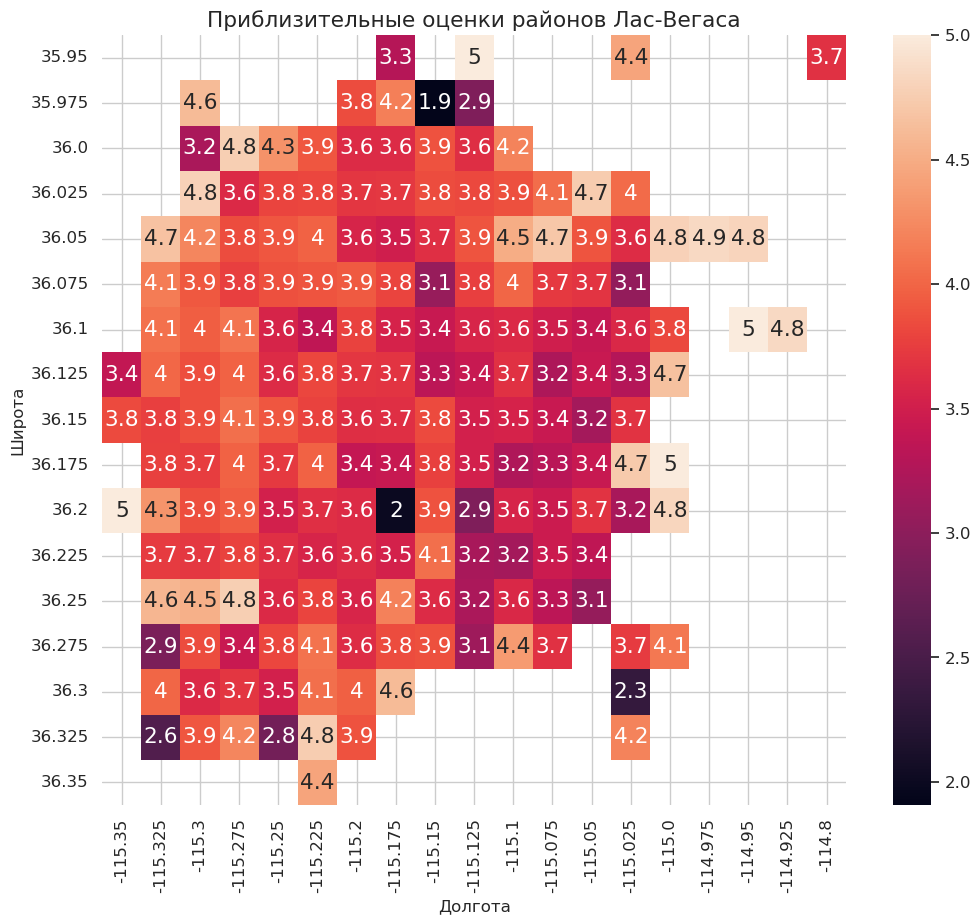

In [58]:
plt.figure(figsize=(12, 10))
piv_mean = pd.pivot_table(
    data=data_new[
        (data_new.longitude > -115.34)
        & (data_new.longitude < -114.5)
        & (data_new.latitude > 35.95)
        & (data_new.latitude < 36.35)
    ],
    index=lat,
    columns=lon,
    values="mean_rating",
    aggfunc="mean",
)

with plt.style.context(
    {"axes.labelsize": 12, "xtick.labelsize": 12, "ytick.labelsize": 12}
):
    ax = sns.heatmap(piv_mean, annot=True).set(
        xlabel="Долгота",
        ylabel="Широта",
        title="Приблизительные оценки районов Лас-Вегаса",
    )
plt.show()

Полученный график имеет ряд недостатков. Во-первых, не очень правильно судить о районе, если в нем мало компаний. Во-вторых,  на графике цветовая гамма автоматически подстроилась под минимальное и максимальное значения оценки.

Почему эти недостатки могут быть существенными?

**Ответ:** 

1) Чем меньше выборка, тем существеннее выбросы. Это приводит к потери точности. 

2)
* Если предположить, что рейтинг райнов отличается на 0.5, то одних в "плохой" цвет неправильно, ведь качество везде будет +- одинаковым
* Мы получили достаточно равномерное пятно одного цвета в центре города: визуальный анализ затрудняется. Много лучше было бы если цветовая гамма изменялась сильно в пределах от [3, 4.5] и в меньшей степени вне этого интервала.

Оставим районы, в которых имеется информация о не менее $30$ компаний. Построим новый график районов, использовав параметры `vmin` и `vmax` у функции `sns.heatmap`.

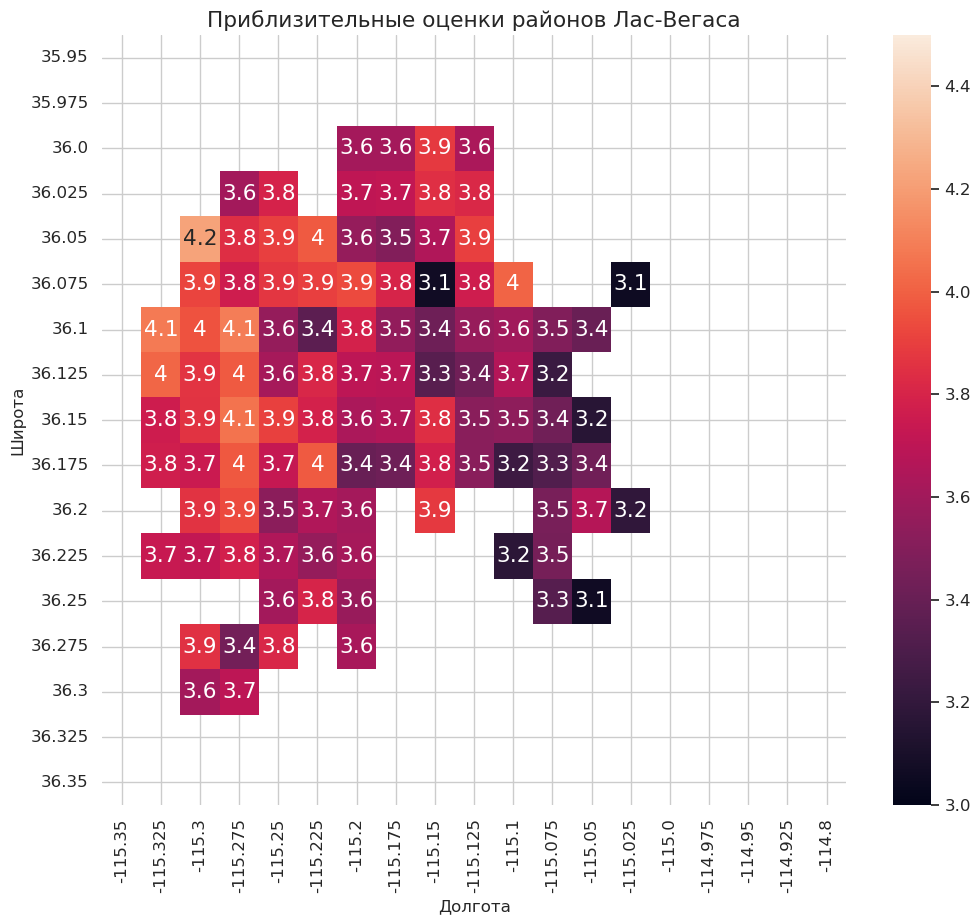

In [59]:
plt.figure(figsize=(12, 10))
piv_number = pd.pivot_table(
    data=data_new[
        (data_new.longitude > -115.34)
        & (data_new.longitude < -114.5)
        & (data_new.latitude > 35.95)
        & (data_new.latitude < 36.35)
    ],
    index=lat,
    columns=lon,
    values="mean_rating",
    aggfunc="count",
)
filter1 = (piv_number >= 30) * piv_mean
filter2 = filter1[filter1 > 0]
with plt.style.context(
    {"axes.labelsize": 12, "xtick.labelsize": 12, "ytick.labelsize": 12}
):
    ax = sns.heatmap(
        filter2, annot=True, vmin=3.0, vmax=4.5
    ).set(
        xlabel="Долгота",
        ylabel="Широта",
        title="Приблизительные оценки районов Лас-Вегаса",
    )
plt.show()

Сравним полученный график с предыдущим и сделаем вывод.

**Вывод:** График стал более информативным: если хочется получить качественные услуги, то стоит выбирать компанию ближе к центру города. Северовосточная часть города может быть неблагоприятным районом, выделяясь черным пятном на фоне остального города.

#### 3. Рестораны

Будем считать компанию рестораном, если в поле `categories` *содержится* слово `restaurant`. Обратим внимание, что часто четкого формата данных нет. Например, данное слово может быть написано как с большой буквы, так и с маленькой; может как разделяться `;`, так и не разделяться. При возникновении недопонимания стоит посмотреть данные.

Составим таблицу, в которой будет информация о всех ресторанах города `N`, для которых имеется не менее $5$ отзывов. Далее построим heatmap-график районов, в котором каждому району сопоставим среднюю оценку по ресторанам этого района. Рассматривать будем только те районы, в которых есть не менее $10$ ресторанов, для каждого из которых есть не менее $5$ отзывов.

In [60]:
# приводим всё к одному регистру, отбираем только те ячейки, которые содержат "restaurant" в качестве подстроки
data_rest_first = data_new[
    data_new["categories"].str.lower().str.contains("restaurant", regex=False)
]
# выделяем рестораны с >=5 отзывами
data_rest = data_rest_first[data_rest_first.reviews_number >= 5]
data_rest

latitude   longitude  \
business_id                                     
Pd52CjgyEU3Rb8co6QfTPw  36.066914 -115.170848   
4srfPk1s8nlm1YusyDUbjg  36.064652 -115.118954   
n7V4cD-KqqE3OXk0irJTyA  36.068259 -115.178877   
Wpt0sFHcPtV5MO9He7yMKQ  36.130013 -115.109310   
W1Yr6c2XDx_RBjb6WsV-aQ  36.170706 -115.190288   
...                           ...         ...   
Kbbm6Vd5UdbP10dwjBghRw  36.040628 -115.191256   
UpW3jyJ3_kTG7oDSflwnMA  36.114816 -115.230970   
e2ApirIzYID9xIye0r_gKQ  36.271006 -115.264392   
Fv4EXwV30rwGD2NzN1ekgA  36.100067 -115.127347   
6HdzmAatFoB8UDep4n9QIw  36.095080 -115.296775   

                                                               categories  \
business_id                                                                 
Pd52CjgyEU3Rb8co6QfTPw  Nightlife;Bars;Barbeque;Sports Bars;American (...   
4srfPk1s8nlm1YusyDUbjg                   Fast Food;Restaurants;Sandwiches   
n7V4cD-KqqE3OXk0irJTyA  Arcades;Arts & Entertainment;Gastropubs;Restau...   
Wpt0sFHcPtV5MO9He7yMKQ                      Restaurants;Fast Food;Burgers   
W1Yr6c2XDx_RBjb6WsV-aQ  Restaurants;Cafes;American (New);Bars;Nightlif...   
...                                                                   ...   
Kbbm6Vd5UdbP10dwjBghRw                      Restaurants;Fast Food;Burgers   
UpW3jyJ3_kTG7oDSflwnMA                                   Restaurants;Thai   
e2ApirIzYID9xIye0r_gKQ  Salad;Breakfast & Brunch;Sandwiches;Burgers;Re...   
Fv4EXwV30rwGD2NzN1ekgA       Asian Fusion;Restaurants;Japanese;Sushi Bars   
6HdzmAatFoB8UDep4n9QIw  Breakfast & Brunch;American (New);American (Tr...   

                                                         name  mean_rating  \
business_id                                                                  
Pd52CjgyEU3Rb8co6QfTPw              "Flight Deck Bar & Grill"     3.769231   
4srfPk1s8nlm1YusyDUbjg                               "Subway"     2.666667   
n7V4cD-KqqE3OXk0irJTyA                            "GameWorks"     3.117479   
Wpt0sFHcPtV5MO9He7yMKQ                           "McDonald's"     2.150000   
W1Yr6c2XDx_RBjb6WsV-aQ  "Divine Cafe at the Springs Preserve"     4.050000   
...                                                       ...          ...   
Kbbm6Vd5UdbP10dwjBghRw                      "In-N-Out Burger"     4.196078   
UpW3jyJ3_kTG7oDSflwnMA                 "Archi's Thai Kitchen"     3.994695   
e2ApirIzYID9xIye0r_gKQ                          "Farmer Boys"     2.735955   
Fv4EXwV30rwGD2NzN1ekgA                        "Gorilla Sushi"     4.424490   
6HdzmAatFoB8UDep4n9QIw                                 "IHOP"     3.000000   

                        reviews_number  
business_id                             
Pd52CjgyEU3Rb8co6QfTPw              13  
4srfPk1s8nlm1YusyDUbjg               6  
n7V4cD-KqqE3OXk0irJTyA             349  
Wpt0sFHcPtV5MO9He7yMKQ              20  
W1Yr6c2XDx_RBjb6WsV-aQ             140  
...                                ...  
Kbbm6Vd5UdbP10dwjBghRw             255  
UpW3jyJ3_kTG7oDSflwnMA             377  
e2ApirIzYID9xIye0r_gKQ             178  
Fv4EXwV30rwGD2NzN1ekgA             245  
6HdzmAatFoB8UDep4n9QIw              82  

[5476 rows x 6 columns]

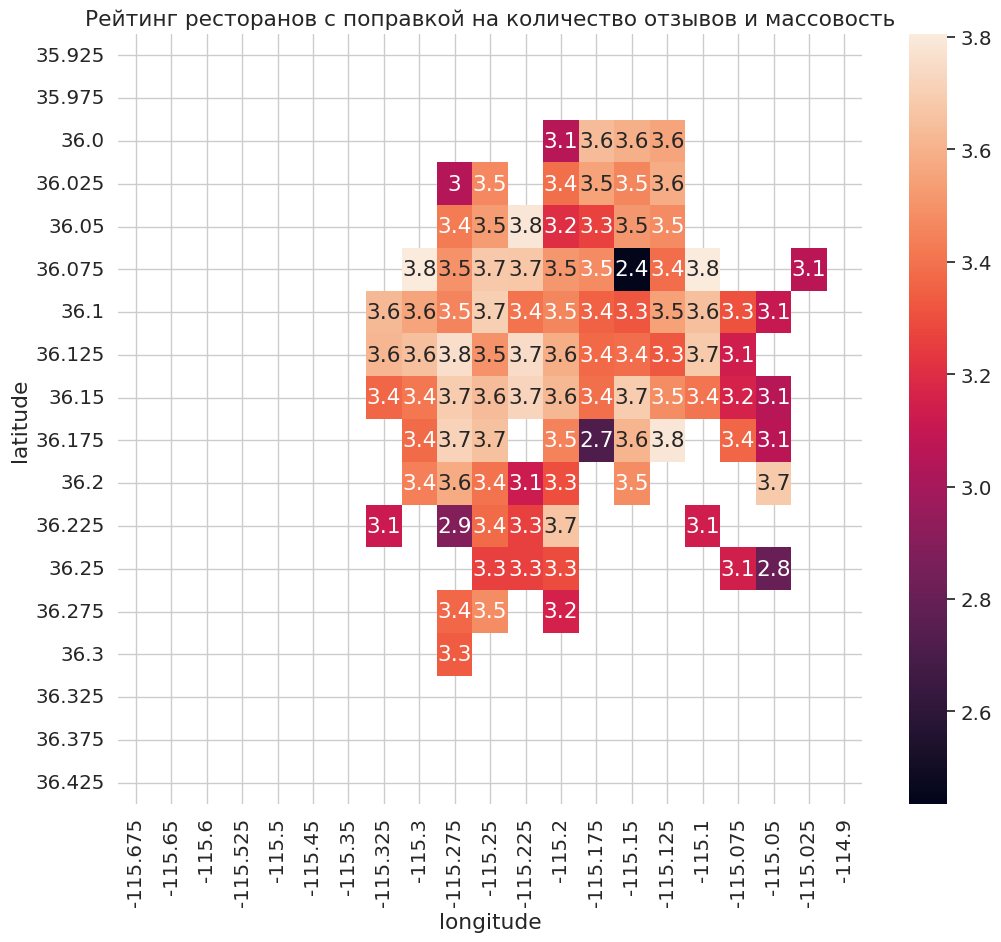

In [61]:
plt.figure(figsize=(12, 10))
rest_piv_mean = pd.pivot_table(
    data=data_rest, index=lat, columns=lon, values="mean_rating", aggfunc="mean"
)

rest_piv_number = pd.pivot_table(
    data=data_rest,
    index=lat,
    columns=lon,
    values="mean_rating",
    aggfunc="count",
)

filter_data1 = (rest_piv_number >= 10) * rest_piv_mean
filter_data2 = filter_data1[filter_data1 > 0]
sns.heatmap(filter_data2, annot=True)
plt.title("Рейтинг ресторанов с поправкой на количество отзывов и массовость")
plt.show()

Чем полезны ограничения снизу на количество отзывов для ресторана и количество ресторанов в районе?

**Ответ:** 

* Нижняя граница на количество отзывов на ресторан отсекает малоизвестные места. 
* Нижняя граница на количество ресторанов в районе позволяет не делать лишних выводов о районе из-за малого количества заведений в нем. 

Как было замечено выше такой подход повышает информативность графика.

Кот Василий из города `N` очень придирчив к выбору ресторана. Он доверяет только ресторанам с высоким рейтингом, который основывается на большом количестве отзывов. Напечатаем в виде таблицы информацию $10$ ресторанах с самым большим рейтингом в порядке убывания рейтинга. Для каждого из этих ресторанов должно быть не менее $50$ отзывов. По каждому ресторану выведем следующую информацию: название ресторана, средняя оценка, количество отзывов, географические координаты, категории.

In [62]:
data_rest_rev50 = data_rest[data_rest.reviews_number >= 50].sort_values(
    by="mean_rating", ascending=False
)
rest_top10 = data_rest_rev50[
    [
        "name",
        "mean_rating",
        "reviews_number",
        "longitude",
        "latitude",
        "categories",
    ]
].head(10)
rest_top10.style.hide(axis="index")

Нанесем на карту все рестораны со средней оценкой не менее $4.7$, которая посчитана по не менее $50$ отзывам. Отдельным цветом отметьте 10 ресторанов, которые мы получили ранее.

In [63]:
# подготовим данные для графика
top_restorants = data_rest_rev50[data_rest_rev50.mean_rating >= 4.7]
top_restorants.insert(0, "Top 10", top_restorants.index)
top_restorants["Top 10"] = top_restorants["Top 10"].apply(
    lambda x: "yes" if x in rest_top10.index else "no"
)

/tmp/ipykernel_20380/154166127.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [64]:
fig2 = px.scatter_mapbox(
    top_restorants,
    lat="latitude",
    lon="longitude",
    center=dict(lat=36.14, lon=-115.2),
    hover_name="name",
    color="Top 10",
    color_continuous_scale="hot",
    hover_data="mean_rating",
    zoom=10,
    mapbox_style="stamen-terrain",
)
fig2.update_layout(mapbox_style="open-street-map")
fig2.write_html("map_top_rest.html")
fig2

Охарактеризуйте кота Василия, а также сделайте общий вывод по задаче.

**Вывод:** 
Кот Василий обеспеченный человек, который ходит в лучшие рестораны города и не любит рисковать. Он понимает, что оценка объективна лишь тогда, когда основывается на большой выборке.

Наш анализ был достаточно объемным.

Для начала мы выяснили, что в сервисе Yelp больше всего отзывов на компании города Лас-Вегас. Далее мы перешли к рассмотрению компаний этого города.
* Нанеся их местоположение на график, мы поняли, что для большей наглядности стоит воспользоваться интерактивной картой
* Интерактивная карта позволила выделить улицы с наибольшим скоплением компаний

Далее мы разделили город на районы, оценивая каждый из них по входящим туда компаниям.
* Тепловые карты помогли понять, что лучшие районы находятся в северо-западной части города

Проведя общий анализ предоставляемых услуг мы сфокусировали свое внимание на ресторанном бизнесе. Если не считать окраин, то средние оценки лежат в интервале [3, 4] баллов.

Отдельно для кота Василия мы нашли лучшие 10 ресторанов города, выделив координаты каждого на карте.
